# 0. 구글 드라이브와 연결 및 각종 라이브러리 설정

### 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 65.9 MB/s 


### 필수 라이브러리 로드

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report

### 폴더 경로 지정

In [4]:
path = '/content/gdrive/MyDrive/FINAL_SUBMIT/'

# 1. 데이터 로드

### 데이터 로드 및 최종 점검

In [ ]:
data = pd.read_excel(path+'final_data.xlsx', engine='openpyxl')

In [ ]:
data.head(2)

,document,label
0,어릴 때 보고 지금 다시 봐도 재밌어ㅋㅋ,1
1,디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1


# 2. 학습용 데이터와 테스트용 데이터 나누기

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42,stratify = data['label'], shuffle=True)

In [ ]:
train_data.shape, test_data.shape

((219676, 2), (73226, 2))

In [ ]:
print("train_data 클래스별 샘플 개수:\n",
     {n: v for n, v in zip([0, 1], np.bincount(train_data['label']))}, '긍정의 비율:', train_data['label'].sum()/train_data.shape[0]) 
print("test_data 클래스별 샘플 개수:\n",
     {n: v for n, v in zip([0, 1], np.bincount(test_data['label']))}, '긍정의 비율:', test_data['label'].sum()/test_data.shape[0]) 

# 잘 나눠진 것을 볼 수 있다.

train_data 클래스별 샘플 개수:
 {0: 136320, 1: 83356} 긍정의 비율: 0.3794497350643675
test_data 클래스별 샘플 개수:
 {0: 45440, 1: 27786} 긍정의 비율: 0.3794553846994237


# 3. 토큰화

### 불용어(조사, 접사 등) 제거 및 토큰화 진행

In [ ]:
stopwords = ['ㅋ', 'ㅎ', 'ㅠ', 'ㅉ', 'ㅡ']

In [ ]:
okt = Okt()

In [ ]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.pos(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word, pos in tokenized_sentence if (not word in stopwords) and (not pos in ['Josa', 'Eomi', 'PreEomi', 'Suffix', 'Unknown'])] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 219676/219676 [09:41<00:00, 377.71it/s]


In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.pos(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word, pos in tokenized_sentence if (not word in stopwords) and (not pos in ['Josa', 'Eomi', 'PreEomi', 'Suffix', 'Unknown'])] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 73226/73226 [03:49<00:00, 319.40it/s]


In [ ]:
X_train[:2]

[['원작', '감동', '없다', '화려하다', '남다', '최악', '작품'], ['답답하다', '죽다', '줄', '알다']]

### 단어 집합 생성

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
len(tokenizer.word_index)

38703

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 38703
등장 빈도가 2번 이하인 희귀 단어의 수: 18872
단어 집합에서 희귀 단어의 비율: 48.76107795261349
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0970561655961744


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19832


### 정수 인코딩 진행

In [ ]:
tokenizer = Tokenizer(vocab_size) #	the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

# tokenizer를 저장

In [ ]:
print(X_train[0])    # 예시

[258, 59, 5, 797, 133, 148, 98]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

# 빈 샘플들을 제거
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

# 주의: 한번만 실행해야함

219491
219491
73156
73156


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 66
리뷰의 평균 길이 : 9.748017002975065


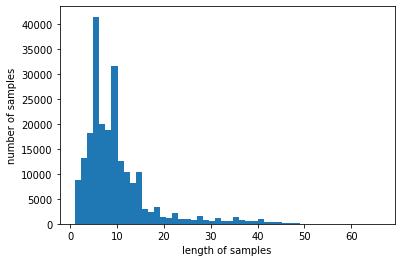

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 94.89136228820317


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
X_train

array([[    0,     0,     0, ...,   133,   148,    98],
       [    0,     0,     0, ...,   165,    83,    79],
       [    0,     0,     0, ..., 14995,    48,   733],
       ...,
       [    0,     0,     0, ...,    99,   175,    12],
       [    0,     0,     0, ...,   603,    33,    57],
       [    0,     0,     0, ...,    51,    43,     1]], dtype=int32)

In [ ]:
np.save(path+'X_train.npy', X_train)
np.save(path+'X_test.npy', X_test)

np.save(path+'y_train.npy', y_train)
np.save(path+'y_test.npy', y_test)

# 4. 모델 생성 및 학습

### 훈련 데이터와 테스트 데이터 로드

In [5]:
X_train = np.load(path+'X_train.npy', allow_pickle=True)
X_test = np.load(path+'X_test.npy', allow_pickle=True)

y_train = np.load(path+'y_train.npy', allow_pickle=True)
y_test = np.load(path+'y_test.npy', allow_pickle=True)

### LSTM 모델로 훈련

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(path+'best_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2736/2744 [============================>.] - ETA: 0s - loss: 0.3795 - acc: 0.8333
Epoch 1: val_acc improved from -inf to 0.84858, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_lstm_model.h5
2744/2744 [==============================] - 28s 7ms/step - loss: 0.3794 - acc: 0.8334 - val_loss: 0.3477 - val_acc: 0.8486
Epoch 2/15
2741/2744 [============================>.] - ETA: 0s - loss: 0.3221 - acc: 0.8637
Epoch 2: val_acc improved from 0.84858 to 0.86068, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_lstm_model.h5
2744/2744 [==============================] - 20s 7ms/step - loss: 0.3221 - acc: 0.8637 - val_loss: 0.3256 - val_acc: 0.8607
Epoch 3/15
2738/2744 [============================>.] - ETA: 0s - loss: 0.2975 - acc: 0.8764
Epoch 3: val_acc improved from 0.86068 to 0.86435, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_lstm_model.h5
2744/2744 [==============================] - 20s 7ms/step - loss: 0.2975 - acc: 0.8764 - val_loss: 0.3182 -

### 훈련된 LSTM 모델 검증

In [6]:
from tensorflow.keras.models import load_model

In [7]:
loaded_model1 = load_model(path+'best_lstm_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model1.evaluate(X_test, y_test)[1]))

2287/2287 [==============================] - 13s 3ms/step - loss: 0.3122 - acc: 0.8692

 테스트 정확도: 0.8692


In [8]:
p1 = loaded_model1.predict(X_test)

In [9]:
predict_label1=[]
for i in range(p1.shape[0]):
  if p1[i,0] > 0.5:
    predict_label1.append(1)
  else:
    predict_label1.append(0)

In [10]:
print('accuracy:',sklearn.metrics.accuracy_score(predict_label1, y_test))
print('f1 score:',sklearn.metrics.f1_score(predict_label1, y_test))

accuracy: 0.8692383399857838
f1 score: 0.8223650003713882


              precision    recall  f1-score   support

           0       0.91      0.88      0.90     47052
           1       0.80      0.85      0.82     26104

    accuracy                           0.87     73156
   macro avg       0.86      0.86      0.86     73156
weighted avg       0.87      0.87      0.87     73156



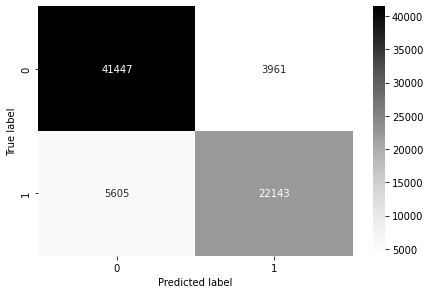

In [14]:
def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Greys)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(predict_label1, y_test)

### BI-LSTM 모델로 훈련

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(path+'best_bilstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
681/686 [============================>.] - ETA: 0s - loss: 0.3881 - acc: 0.8282
Epoch 1: val_acc improved from -inf to 0.84690, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_bilstm_model.h5
686/686 [==============================] - 14s 12ms/step - loss: 0.3880 - acc: 0.8282 - val_loss: 0.3544 - val_acc: 0.8469
Epoch 2/15
682/686 [============================>.] - ETA: 0s - loss: 0.3298 - acc: 0.8596
Epoch 2: val_acc improved from 0.84690 to 0.85754, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_bilstm_model.h5
686/686 [==============================] - 8s 12ms/step - loss: 0.3298 - acc: 0.8597 - val_loss: 0.3330 - val_acc: 0.8575
Epoch 3/15
685/686 [============================>.] - ETA: 0s - loss: 0.3040 - acc: 0.8722
Epoch 3: val_acc improved from 0.85754 to 0.86123, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/best_bilstm_model.h5
686/686 [==============================] - 7s 11ms/step - loss: 0.3040 - acc: 0.8722 - val_loss: 0.3279 - val_

### 훈련된 BI-LSTM 모델 검증

In [17]:
loaded_model2 = load_model(path+'best_bilstm_model.h5')
print("테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test, y_test)[1]))

2287/2287 [==============================] - 11s 4ms/step - loss: 0.3176 - acc: 0.8666
테스트 정확도: 0.8666


In [18]:
p2 = loaded_model2.predict(X_test)

In [19]:
predict_label2=[]
for i in range(p2.shape[0]):
  if p2[i,0] > 0.5:
    predict_label2.append(1)
  else:
    predict_label2.append(0)

In [20]:
print('accuracy:',sklearn.metrics.accuracy_score(predict_label2, y_test))
print('f1 score:',sklearn.metrics.f1_score(predict_label2, y_test))

accuracy: 0.8666274809995079
f1 score: 0.8216498802712633


              precision    recall  f1-score   support

           0       0.90      0.89      0.89     46197
           1       0.81      0.83      0.82     26959

    accuracy                           0.87     73156
   macro avg       0.86      0.86      0.86     73156
weighted avg       0.87      0.87      0.87     73156



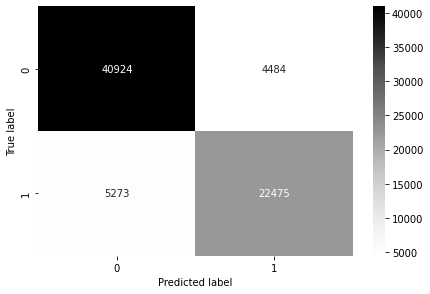

In [21]:
def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Greys)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(predict_label2, y_test)